<a href="https://colab.research.google.com/github/Voronga/dz/blob/main/dz2/3raspredeleniya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!gdown --id 17mf6RUEFOJ19t2zNuFlswSUs7MODwLlk

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=17mf6RUEFOJ19t2zNuFlswSUs7MODwLlk
To: /content/EM_dataset.csv
100% 12.6k/12.6k [00:00<00:00, 16.5MB/s]


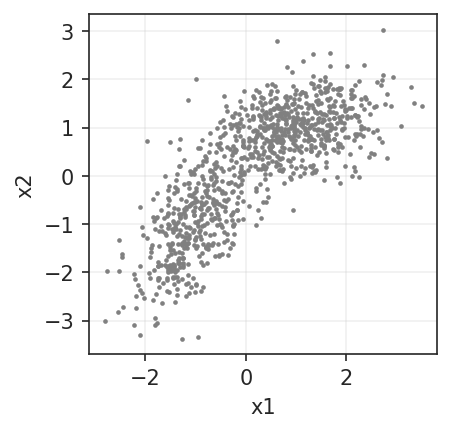

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("ticks")
df = pd.read_csv("EM_dataset.csv")
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, color="grey", linewidth=0, ax=ax)
ax.grid(alpha=0.3)

In [62]:
import numpy as np

def get_random_psd(n=2):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())

params = {
    "phi1" : np.random.uniform(0, 0.5), # Доля точек, принадлежащих к кластеру 1
    "phi2" : np.random.uniform(0, 0.5),

    "mu1" : np.random.normal(0, 1, size=2), # Центр распределения 1
    "mu2" : np.random.normal(0, 1, size=2), # Центр распределения 2
    "mu3" : np.random.normal(0, 1, size=2),
    
    "sigma1" : get_random_psd(), # У 2d Гауссианы таким образом задаётся дисперсия
    "sigma2" : get_random_psd(), # У 2d Гауссианы таким образом задаётся дисперсия
    "sigma3" : get_random_psd()
}

for param in params:
  print(f"{param}:")
  print(params[param], "\n")

phi1:
0.45074828125012545 

phi2:
0.46686501019303517 

mu1:
[-0.51809681 -0.88773576] 

mu2:
[-0.87280721 -0.28080413] 

mu3:
[-0.32853896 -1.14148521] 

sigma1:
[[1.75941324 2.10409318]
 [2.10409318 3.21887401]] 

sigma2:
[[0.88185876 0.04239619]
 [0.04239619 0.13224657]] 

sigma3:
[[4.54494788 0.6488082 ]
 [0.6488082  0.84171691]] 



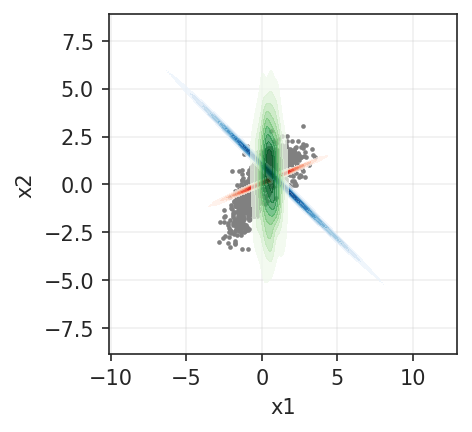

In [47]:
import scipy.stats as stats

hist1 = stats.multivariate_normal(params["mu1"], params["sigma1"]).rvs(size=1000)
hist2 = stats.multivariate_normal(params["mu2"], params["sigma2"]).rvs(size=1000)
hist3 = stats.multivariate_normal(params["mu3"], params["sigma3"]).rvs(size=1000)

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, linewidth=0, ax=ax, color="grey")
sns.kdeplot(x=hist1[:, 0], y=hist1[:, 1], ax=ax, cmap="Reds", fill=True, alpha=0.7)
sns.kdeplot(x=hist2[:, 0], y=hist2[:, 1], ax=ax, cmap="Blues", fill=True, alpha=0.7)
sns.kdeplot(x=hist3[:, 0], y=hist2[:, 1], ax=ax, cmap="Greens", fill=True, alpha=0.7)
ax.grid(alpha=0.3)

In [63]:
from scipy.special import logsumexp

X = df.values

def E_step(X, params, draw=False):
  LogLikelihood = A = np.log([
      stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(X), 
      stats.multivariate_normal(params["mu2"], params["sigma2"]).pdf(X),
      stats.multivariate_normal(params["mu3"], params["sigma3"]).pdf(X)
  ])
  logPrior = B = np.log([1 - params["phi1"] - params["phi2"], params["phi1"], params["phi2"]])
  logPosterior = D = logPrior + LogLikelihood.T
  RealSoftMax = C = logsumexp(logPosterior, axis=1)
  probabilities = np.exp(logPosterior - np.array([RealSoftMax]).T)

  if draw:
    hist1 = stats.multivariate_normal(params["mu1"], params["sigma1"]).rvs(size=1000)
    hist2 = stats.multivariate_normal(params["mu2"], params["sigma2"]).rvs(size=1000)
    hist3 = stats.multivariate_normal(params["mu3"], params["sigma3"]).rvs(size=1000)

    fig, axes = plt.subplots(figsize=(6, 3), dpi=150, ncols=2)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=probabilities[:, 0], linewidth=0,
                    palette="coolwarm", ax=axes[1], s=3, alpha=1)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], linewidth=0, ax=axes[0], s=3, alpha=1, color="grey")
    sns.kdeplot(x=hist1[:, 0], y=hist1[:, 1], ax=axes[0], cmap="Reds", fill=True, alpha=0.5)
    sns.kdeplot(x=hist2[:, 0], y=hist2[:, 1], ax=axes[0], cmap="Blues", fill=True, alpha=0.5)
    sns.kdeplot(x=hist3[:, 0], y=hist3[:, 1], ax=axes[0], cmap="Greens", fill=True, alpha=0.5)
    axes[0].grid(alpha=0.3)
    axes[1].grid(alpha=0.3)
    axes[1].legend().remove()
    axes[0].set_xlim(-4, 4)
    axes[1].set_xlim(-4, 4)
    axes[0].set_ylim(-4, 4)
    axes[1].set_ylim(-4, 4)
    plt.show()

  return RealSoftMax, probabilities

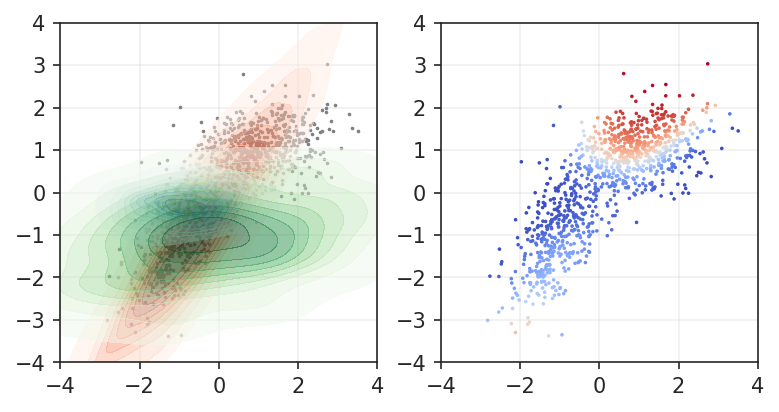

In [64]:
total_prob, probabilities = E_step(X, params, draw=True)

In [68]:
def M_step(X, params, probabilities):
  prob_1 = probabilities[:, 0]
  prob_2 = probabilities[:, 1]
  prob_3 = probabilities[:, 2]

  # Вычисление новых значений
  # Пропорция = prior
  phi1 = prob_1.sum() / len(X)
  phi2 = prob_2.sum() / len(X)

  # Среднее
  mu1 = prob_1.dot(X) / np.sum(prob_1)
  mu2 = prob_2.dot(X) / np.sum(prob_2)
  mu3 = prob_3.dot(X) / np.sum(prob_3)

  # Дисперсия
  sigma1 = (X - mu1).T.dot((X - mu1) * np.array([prob_1]).T) / np.sum(prob_1)
  sigma2 = (X - mu2).T.dot((X - mu2) * np.array([prob_2]).T) / np.sum(prob_2)
  sigma3 = (X - mu3).T.dot((X - mu3) * np.array([prob_3]).T) / np.sum(prob_3)
  
  return {
      "phi1" : phi1, "phi2" : phi2,
      "mu1" : mu1, "mu2" : mu2, "mu3" : mu3,
      "sigma1": sigma1, "sigma2": sigma2, "sigma3": sigma3
  }

In [69]:
def run_EM(X, params, draw=False):
    import imageio
    avg_allprob = []

    while True:
        allprob, probabilities = E_step(X, params, draw=draw)
        avg_allprob.append(np.mean(allprob))
        if len(avg_allprob) > 2 and abs(avg_allprob[-1] - avg_allprob[-2]) < 0.00001:
            break
        params = M_step(X, params, probabilities)
        
    loglikelihood, probabilities = E_step(X, params)
    forecasts = np.argmax(probabilities, axis=1)
    return forecasts, probabilities, avg_allprob

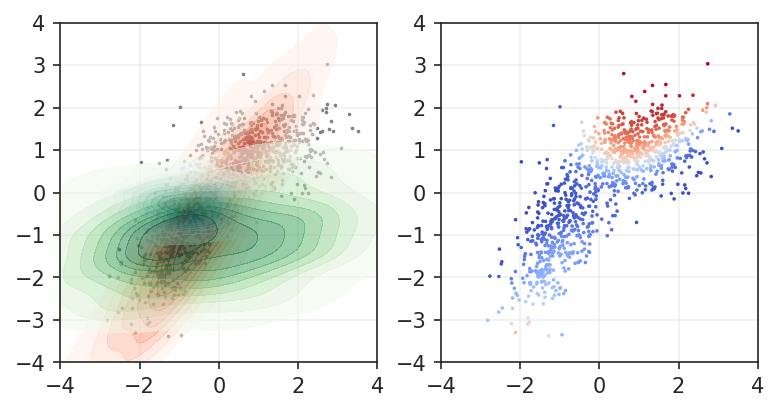

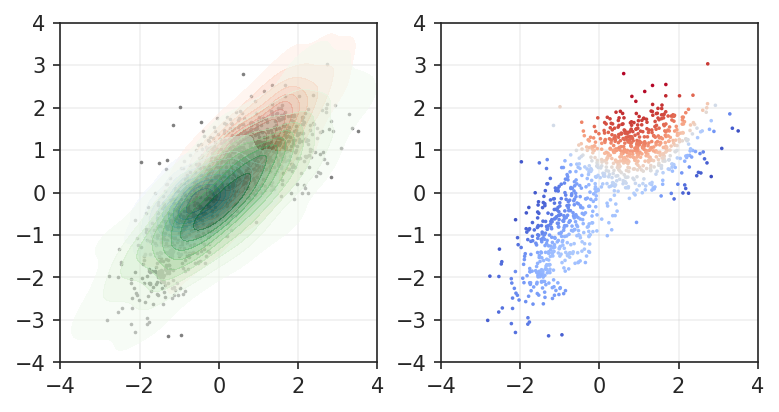

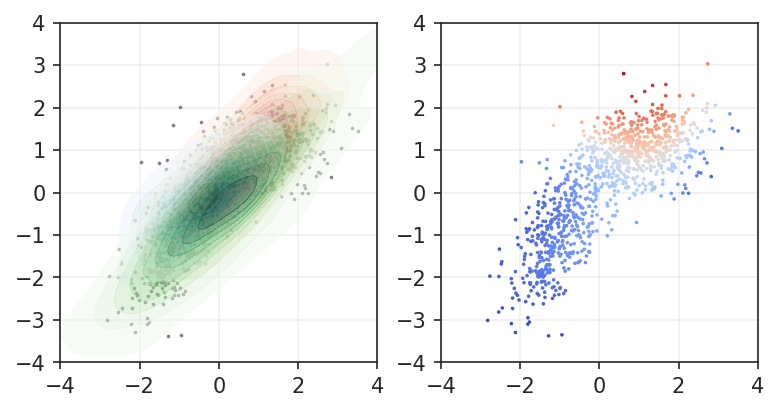

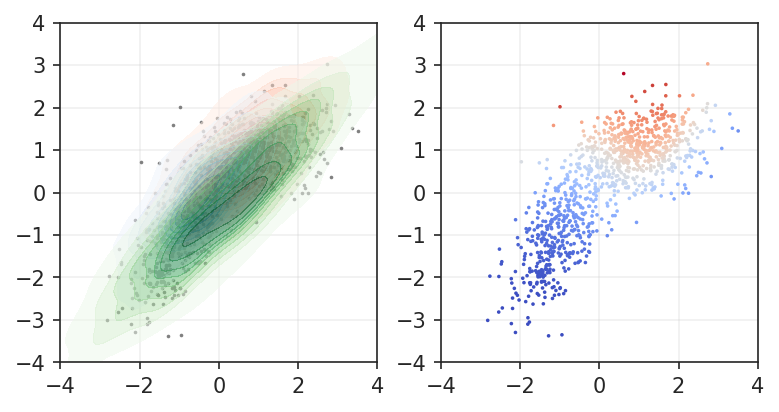

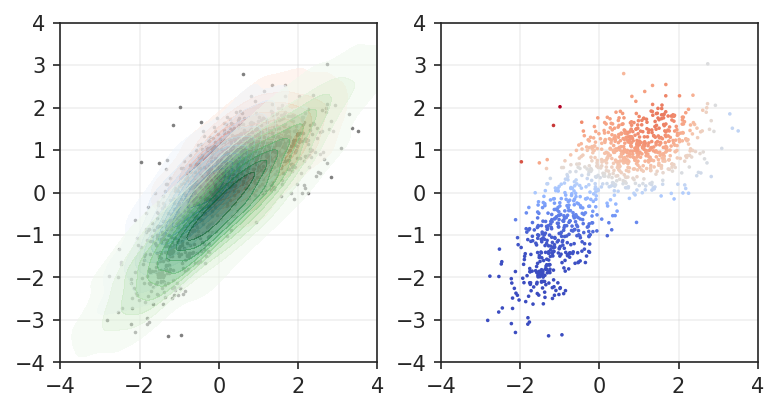

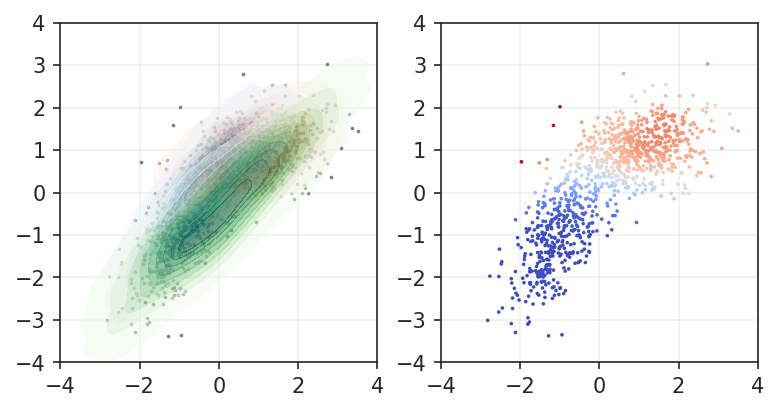

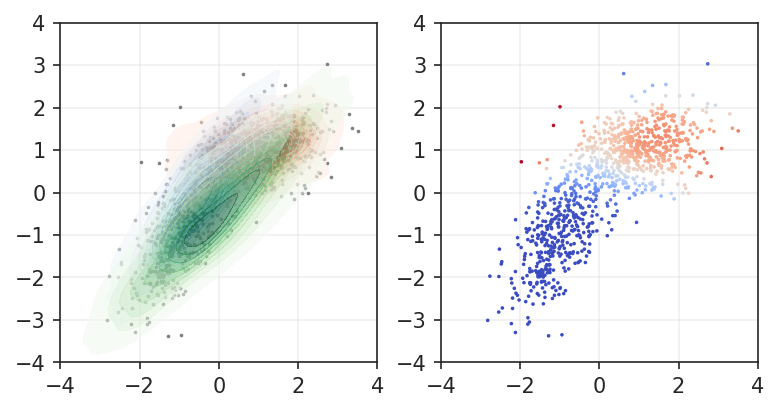

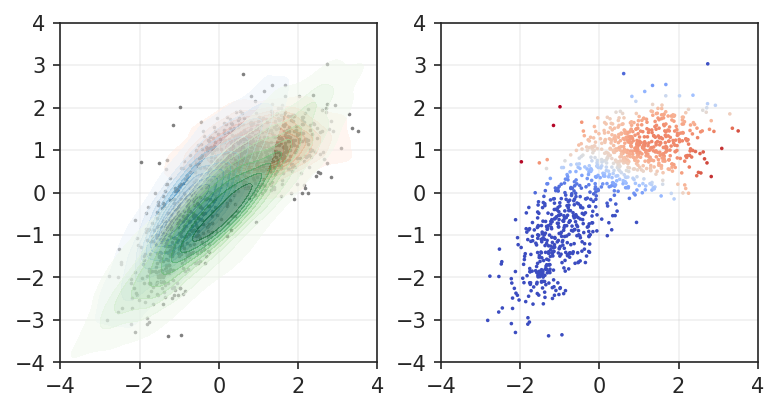

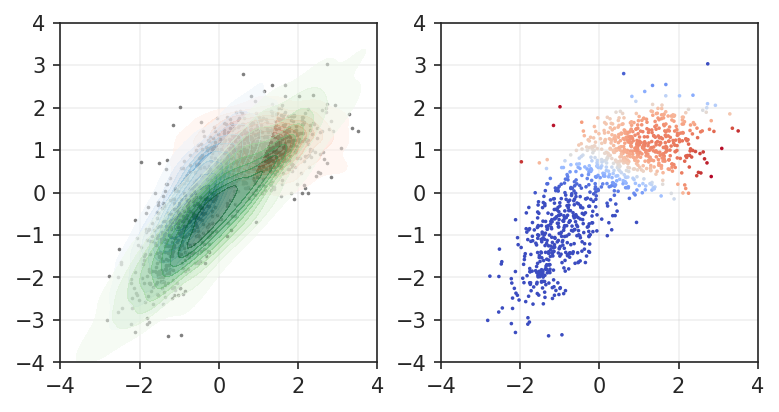

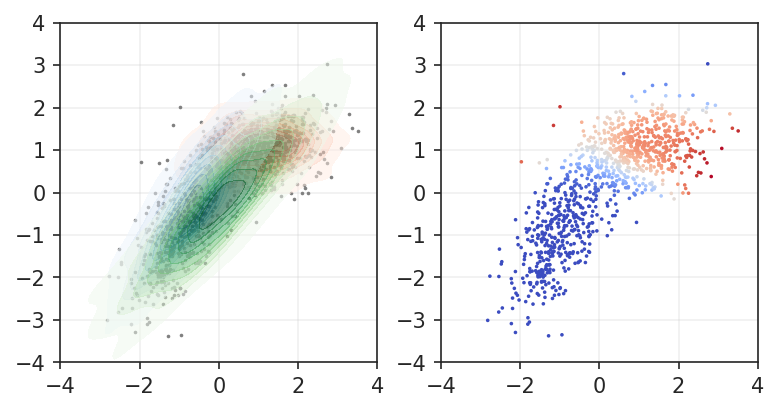

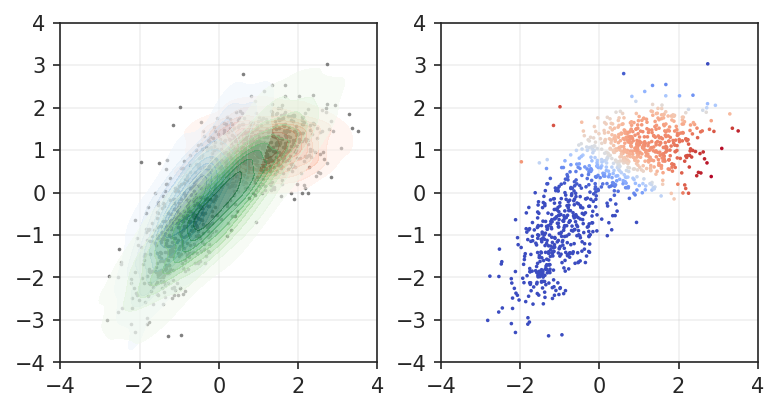

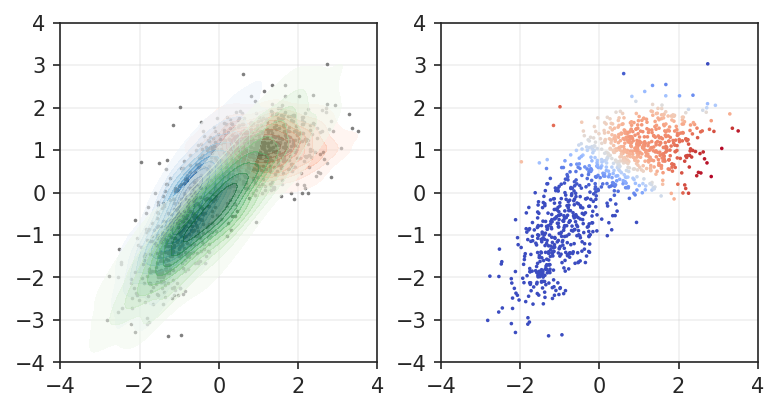

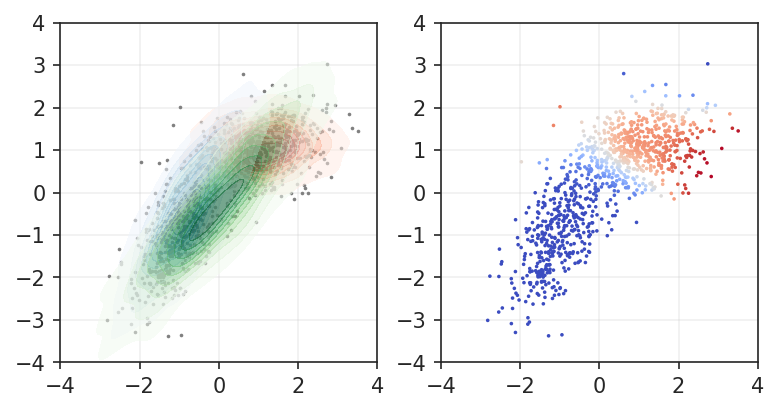

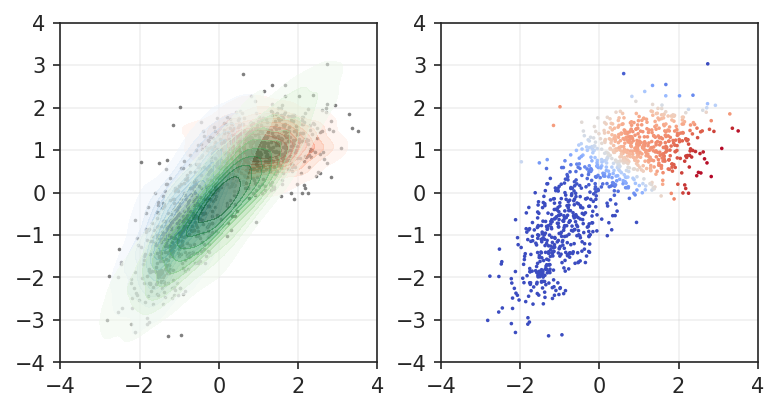

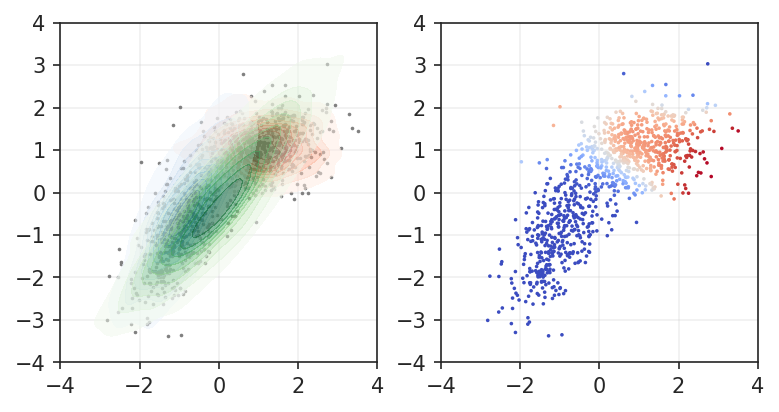

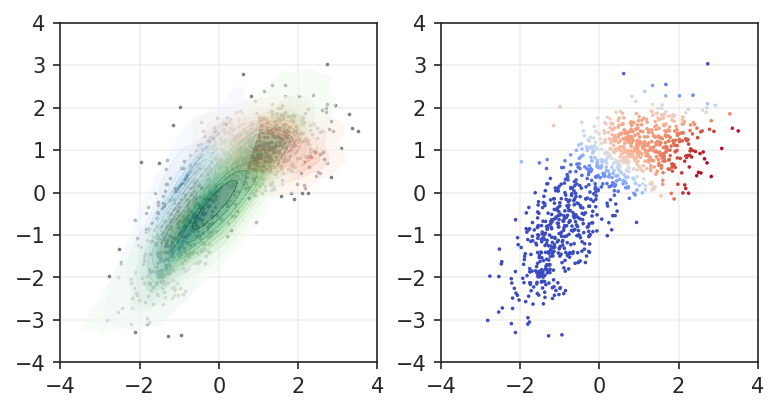

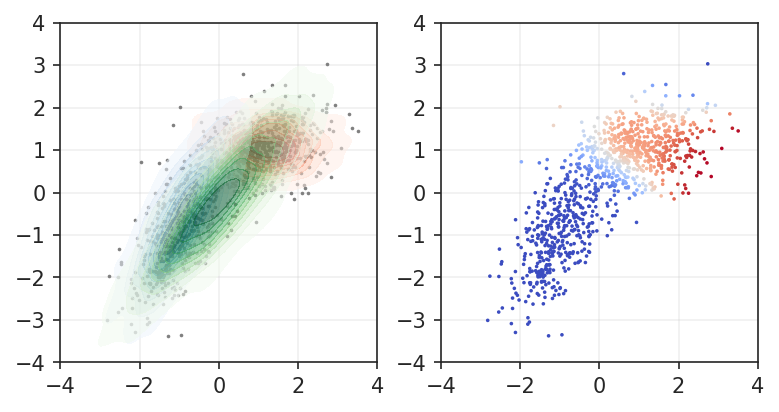

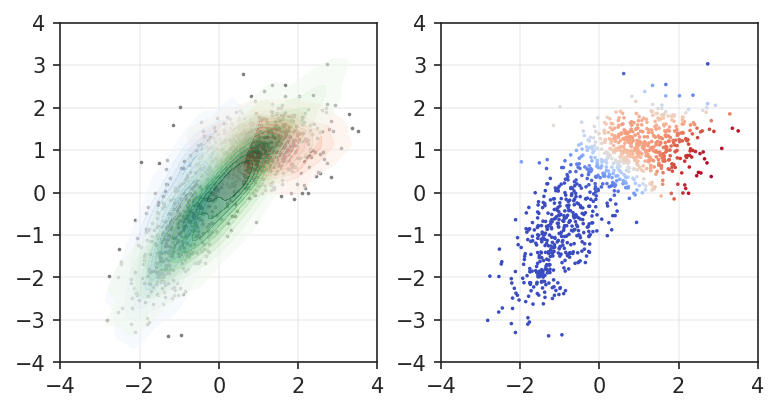

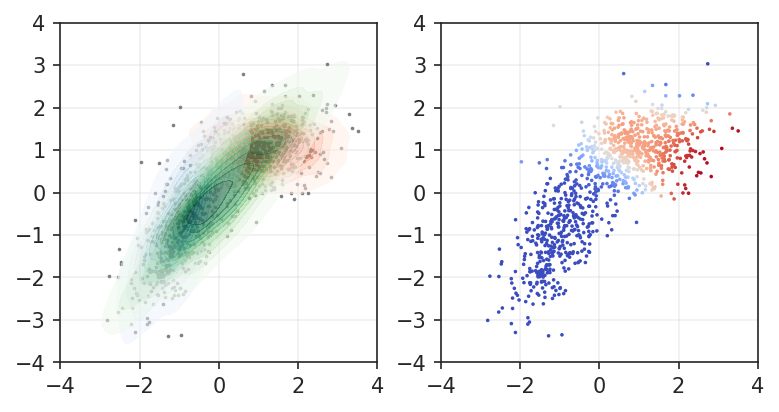

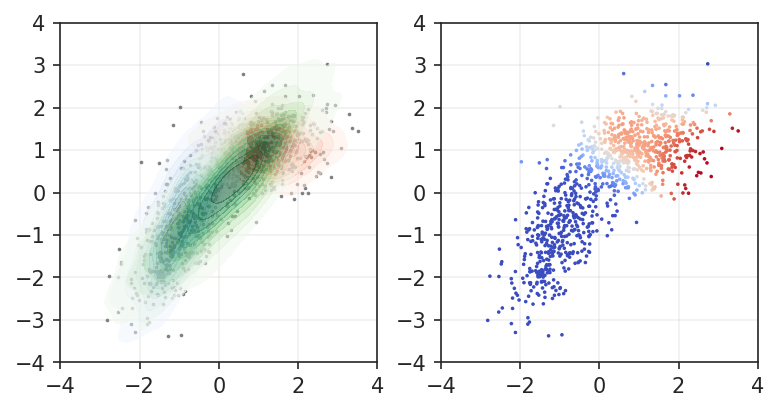

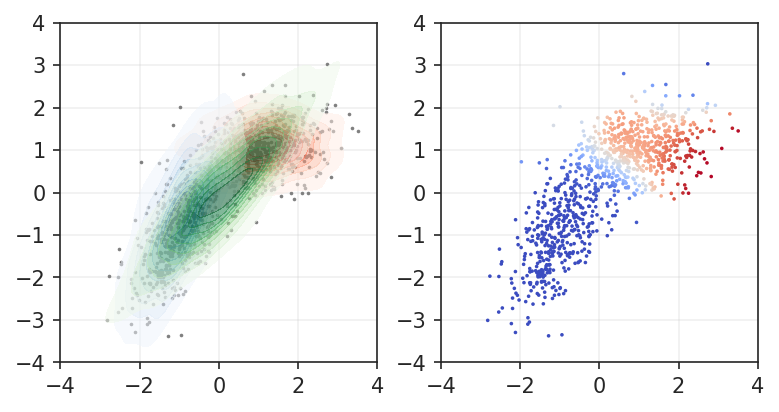

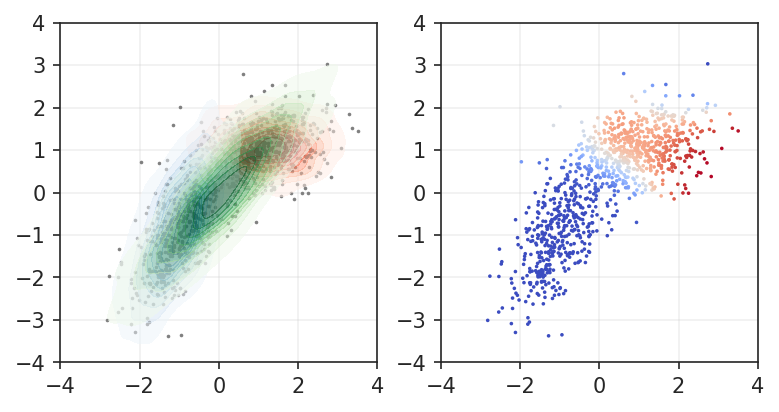

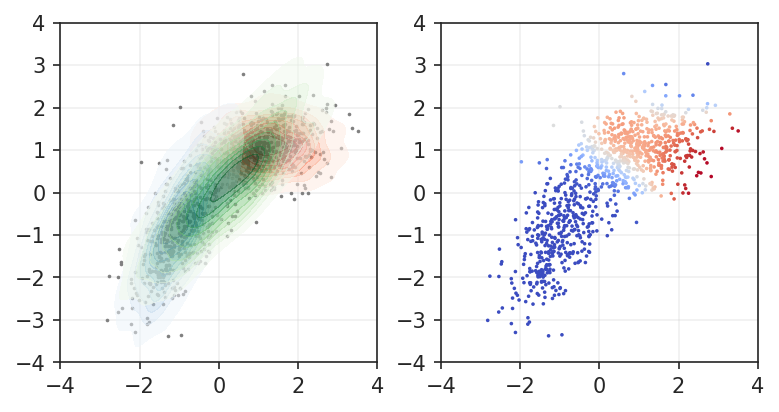

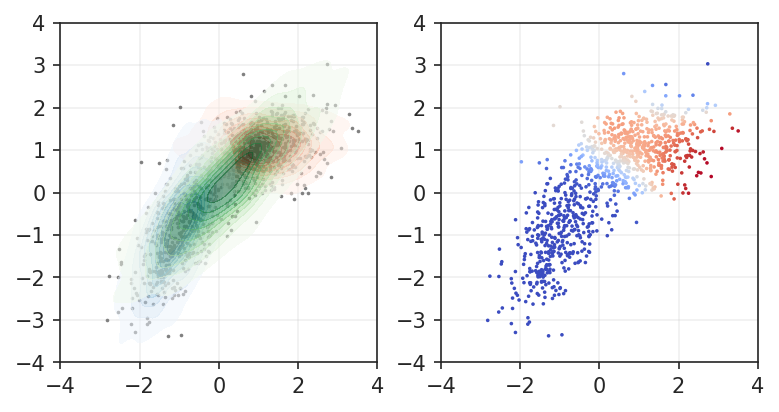

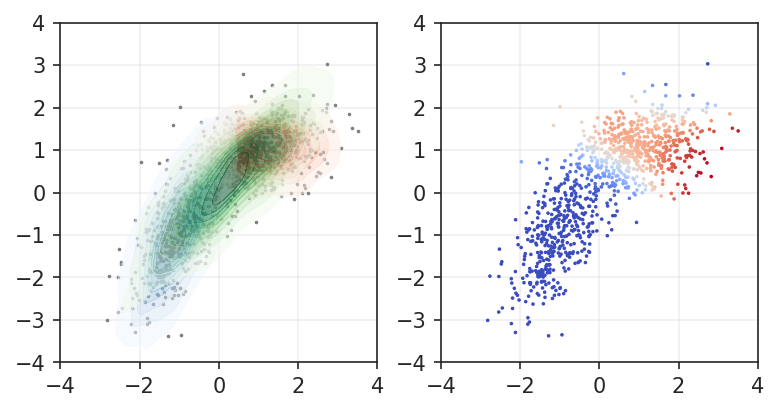

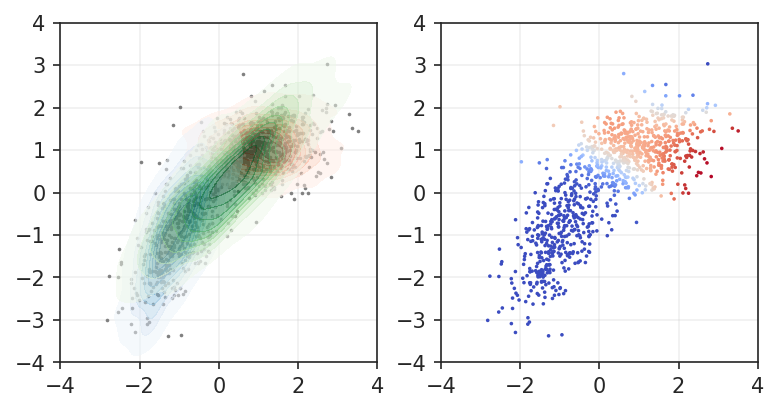

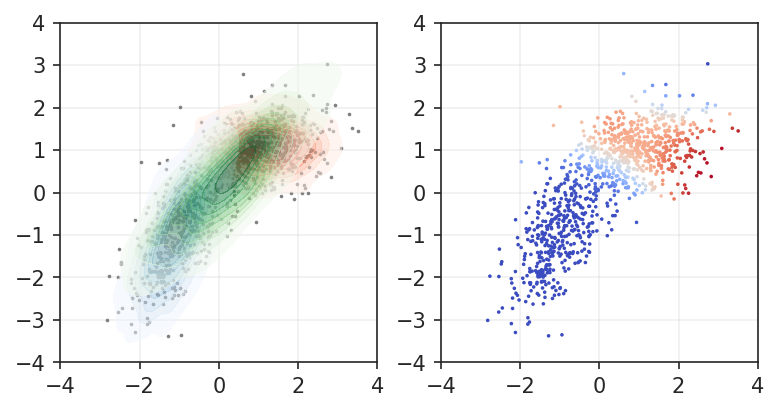

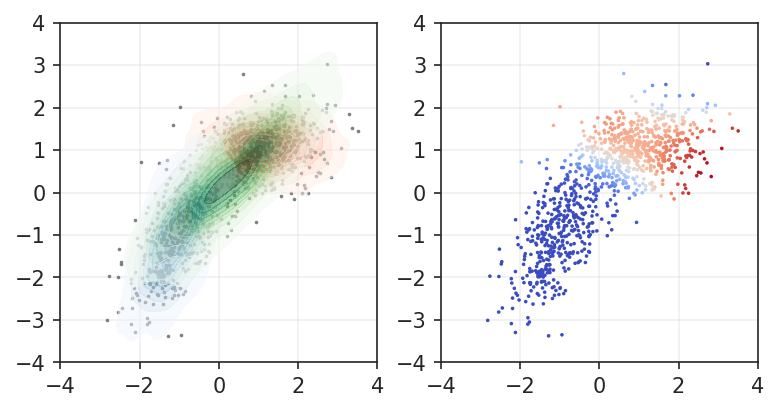

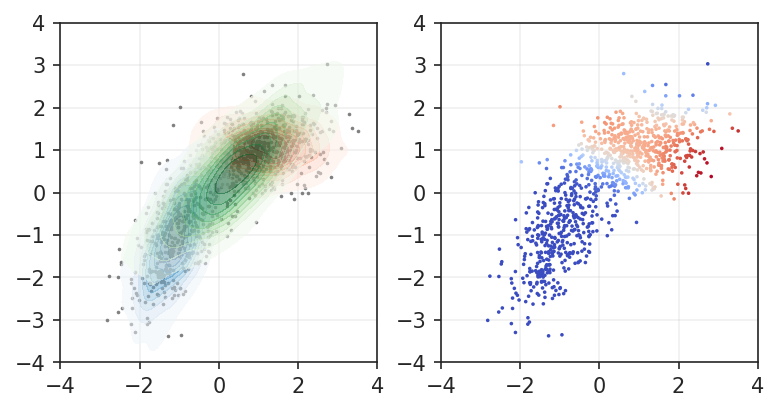

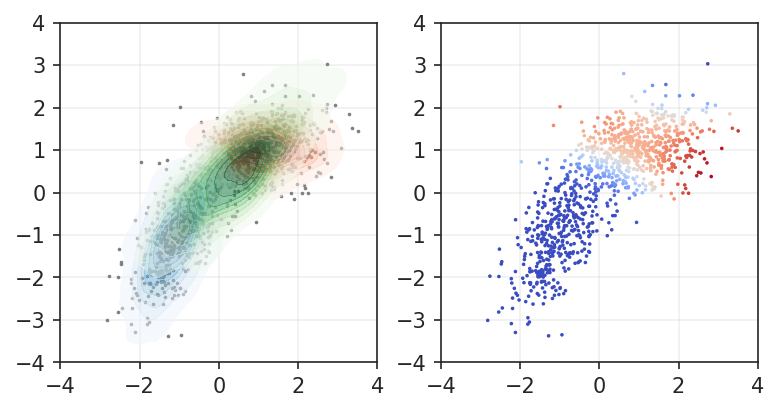

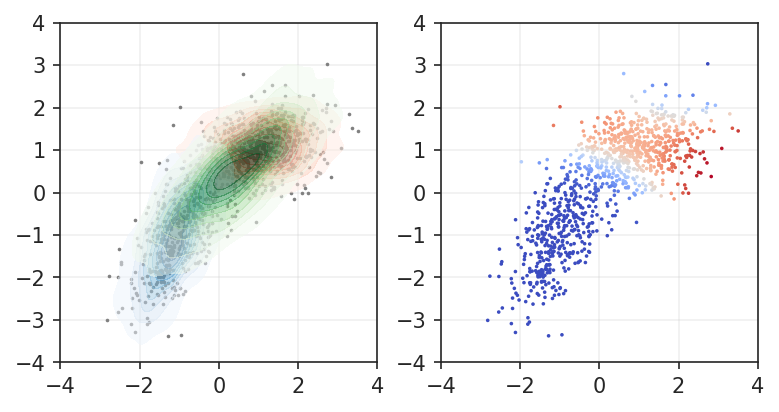

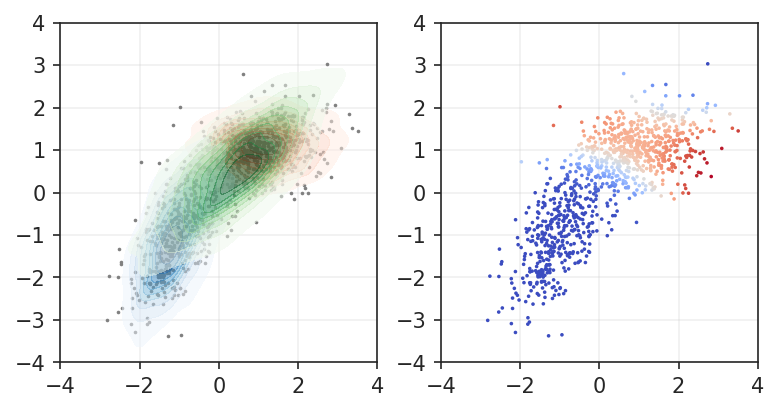

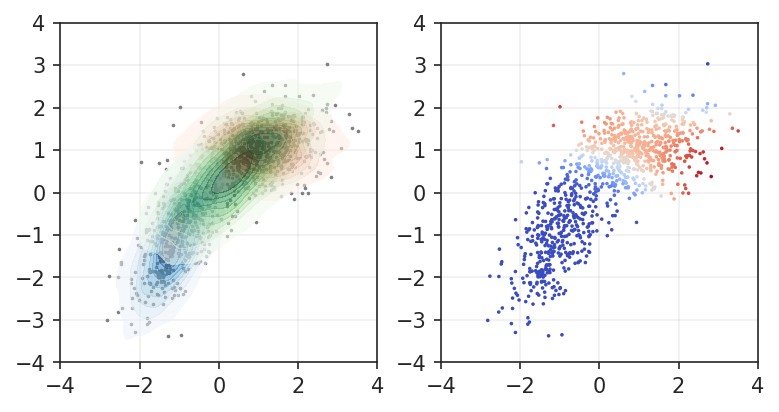

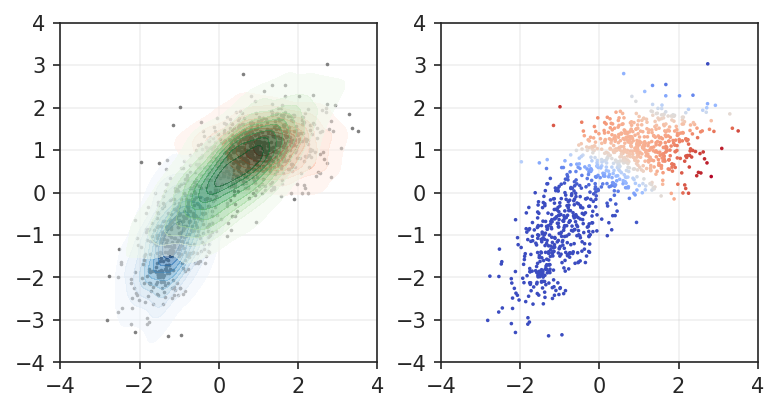

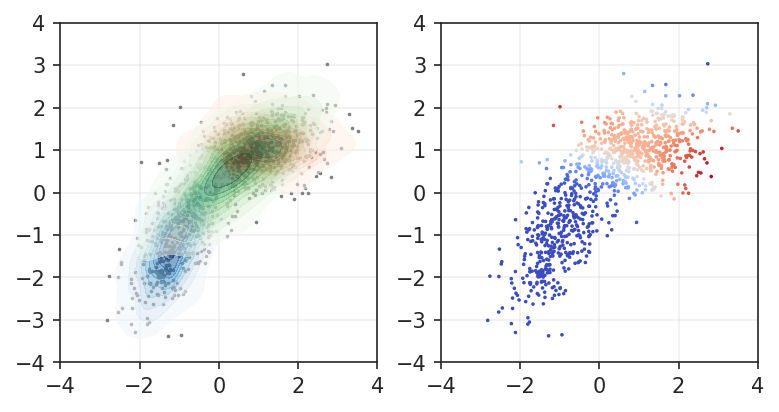

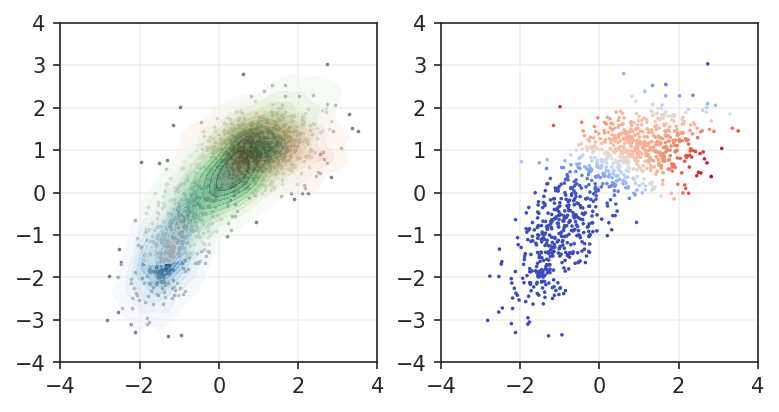

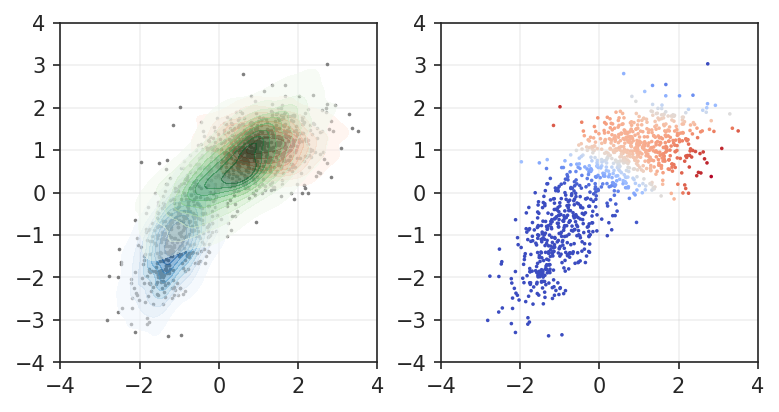

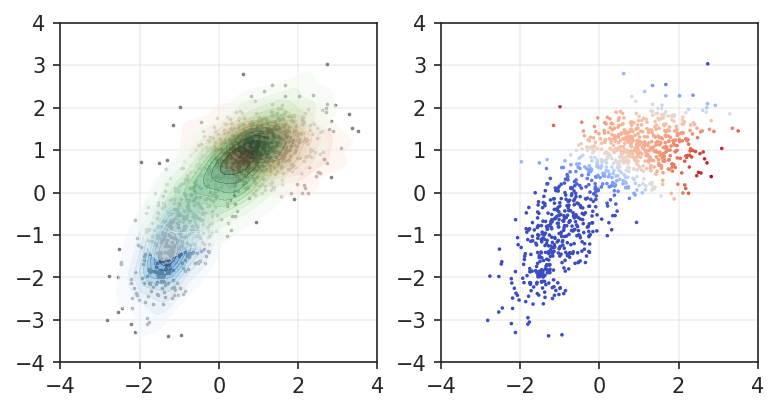

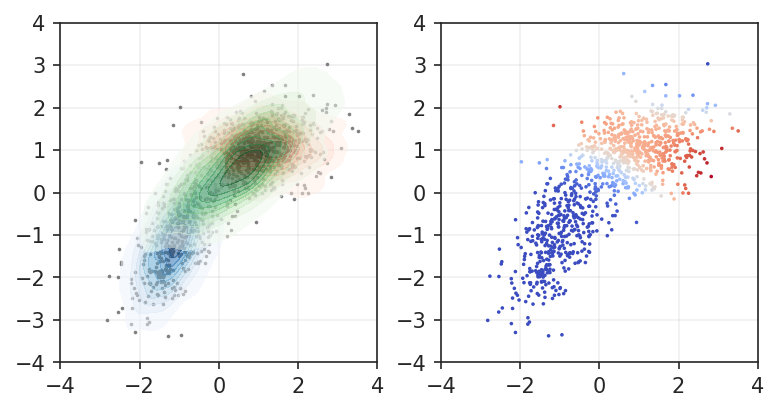

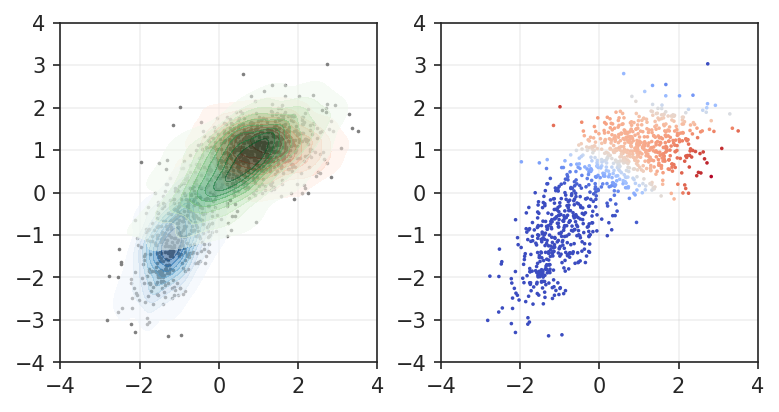

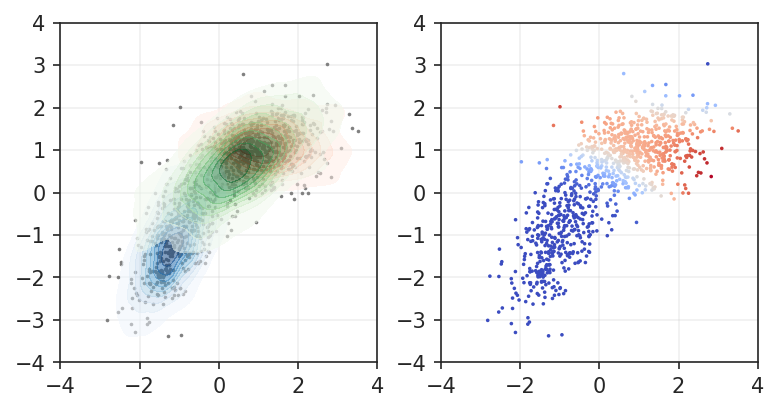

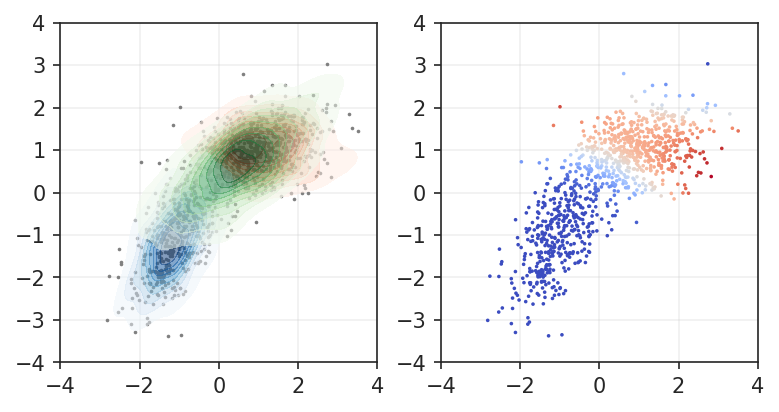

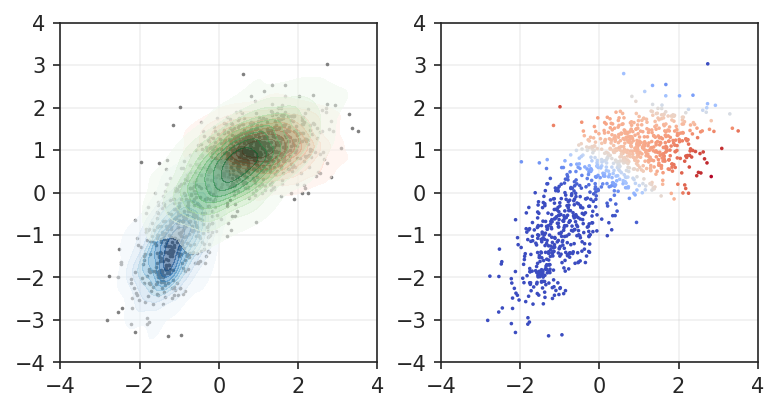

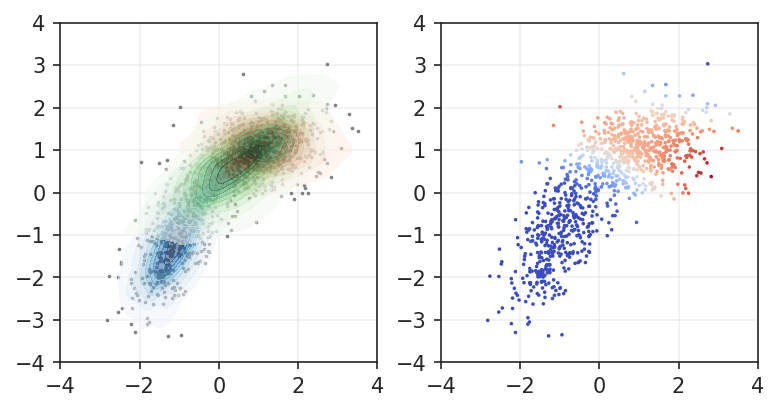

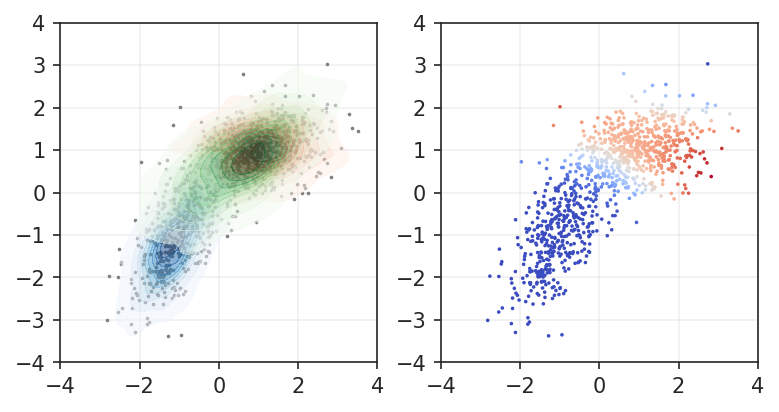

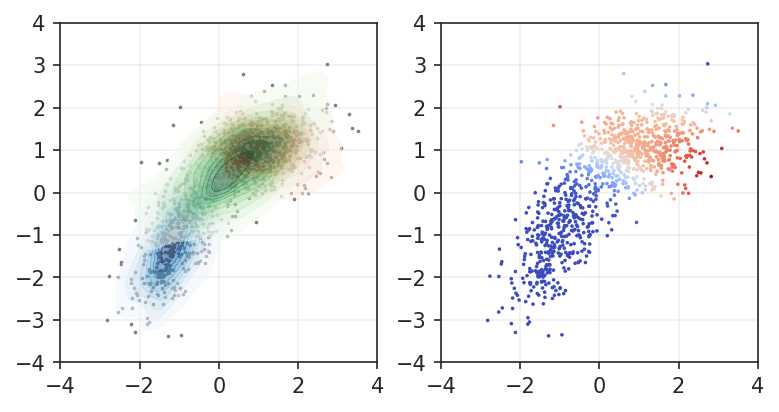

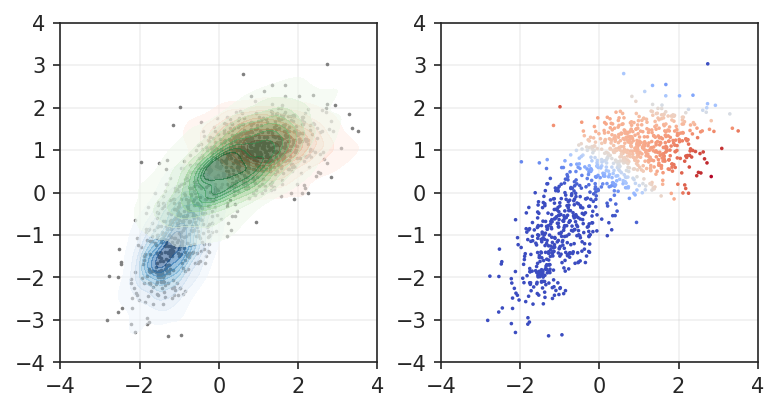

In [70]:
pred, prob, allprob = run_EM(X, params, draw=True)

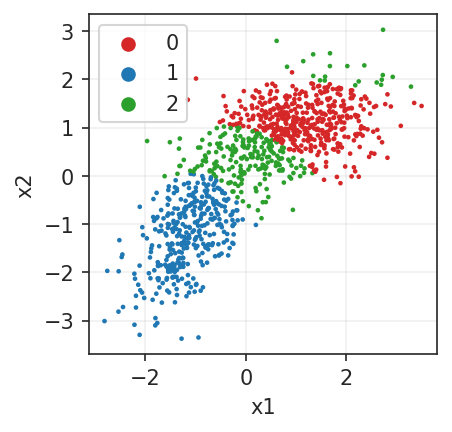

In [86]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, linewidth=0, ax=ax, hue=pred,
                palette={0: sns.color_palette("tab10")[3],
                         1: sns.color_palette("tab10")[0],
                         2: sns.color_palette("tab10")[2]}
                )
ax.grid(alpha=0.3)